<a href="https://colab.research.google.com/github/Giovanni-Tedeschi/QFT/blob/main/QFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Fourier Transform**

In [ ]:
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# QFT

In this section we will build and execute a quantum circuit that does a Quantum Fourier Transform on the state $|110\rangle$. First of all, let' prepare the initial state and check with the *Aer* backend that it is indeed the state that we want. 

Note that in Qiskit the convention is opposite to the one used in the reference paper: the most signifcant bit is at the bottom of the circuit.

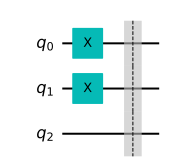

In [ ]:
qft = QuantumCircuit(3)
qft.x(0)
qft.x(1)
qft.barrier()
qft.draw('mpl')

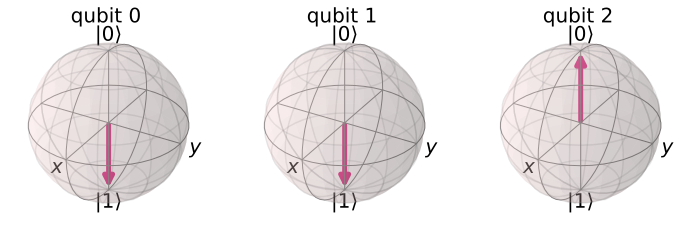

In [ ]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qft, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Now we build the actual QFT circuit and check the final state

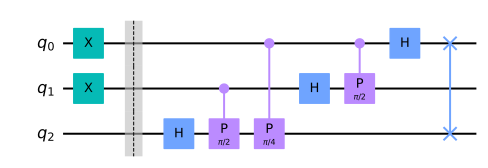

In [ ]:
qft.h(2)
qft.cp(pi/2, 1, 2)
qft.cp(pi/4, 0, 2)
qft.h(1)
qft.cp(pi/2, 0, 1)
qft.h(0)
qft.swap(0,2)
qft.draw('mpl')

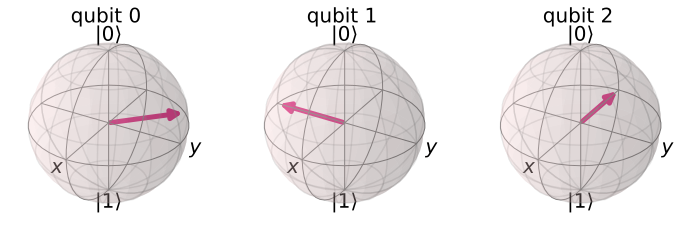

In [ ]:
statevector = execute(qft, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

As can be seen from the states on the Bloch sphere, they correspond to the state $\frac{1}{\sqrt{2^3}}(|0\rangle + e^{3\pi i}|1\rangle)\otimes(|0\rangle + e^{\frac{3}{2}\pi i}|1\rangle)\otimes(|0\rangle + e^{\frac{3}{4}\pi i}|1\rangle)$

Now let's measure all the qubits and try to run this on an actual Quantum Computer.

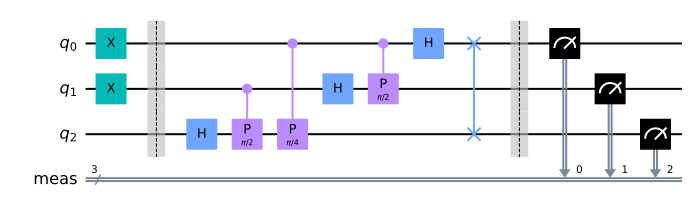

In [ ]:
qft.measure_all()
qft.draw('mpl')

In [ ]:
backend = provider.get_backend('ibmq_santiago')
shots = 2048
job = execute(qft, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


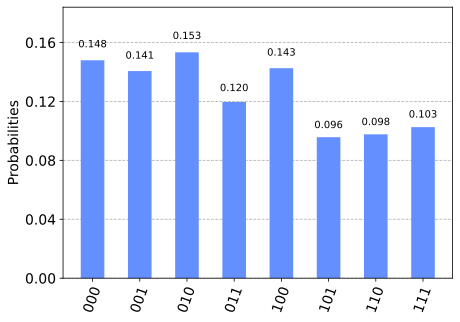

In [ ]:
device_result = job.result()
plot_histogram(device_result.get_counts(qft))

As expected, just random values!

# Inverse QFT

From the states we have obtained in the previus circuit, let's now try to go back from the start, applying an Inverse QFT.

We prepare the initial states, build the circuit that operates the IQFT and check the final states.

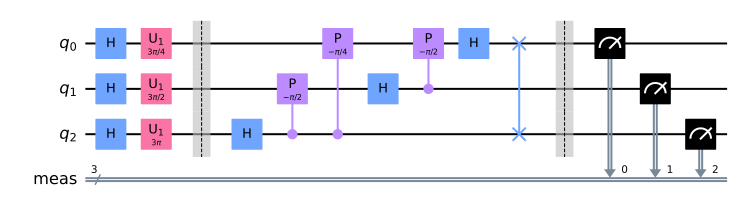

In [ ]:
iqft = QuantumCircuit(3)
for qubit in range(3):
    iqft.h(qubit)
iqft.u1(3*pi/4,0)
iqft.u1(3*pi/2,1)
iqft.u1(3*pi,2)
iqft.barrier()
iqft.h(2)
iqft.cp(-pi/2, 2, 1)
iqft.cp(-pi/4, 2, 0)
iqft.h(1)
iqft.cp(-pi/2, 1, 0) 
iqft.h(0)
iqft.swap(0,2)
iqft.measure_all()
iqft.draw('mpl')

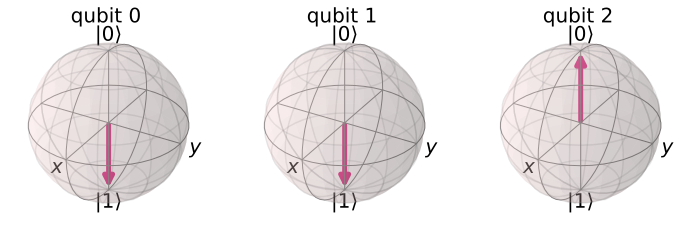

In [ ]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(iqft, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

Let's now run it on an actual Quantum Computer

In [ ]:
shots = 2048
job = execute(iqft, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


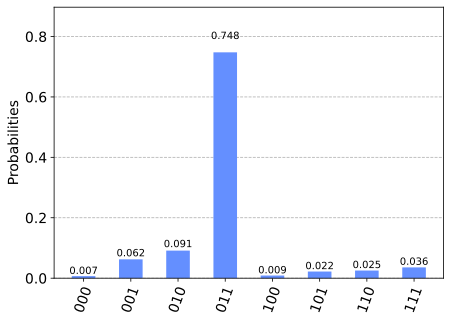

In [ ]:
device_result = job.result()
plot_histogram(device_result.get_counts(iqft))

The result is not bad, but can be better after a calibration of the machine, so let's try that.

First of all, create the calibration circuits.

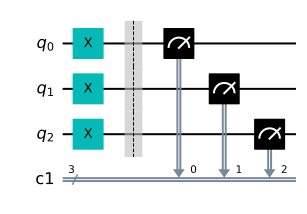

In [ ]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr=iqft.qregs[0], circlabel='measurement_calibration')
cal_circuits[7].draw(output='mpl')

Next, run them on the computer to calibrate it and retrieve the calibration results.

In [ ]:
cal_job = execute(cal_circuits, backend=backend, shots=8192, optimization_level=0)
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


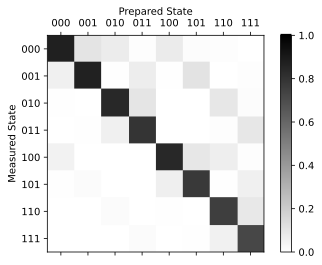

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

Apply the filter to the previous results and see what happens.

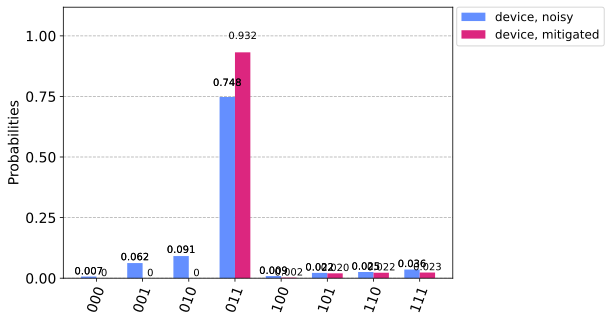

In [ ]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)
device_counts = device_result.get_counts(iqft)
mitigated_counts = mitigated_result.get_counts(iqft)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

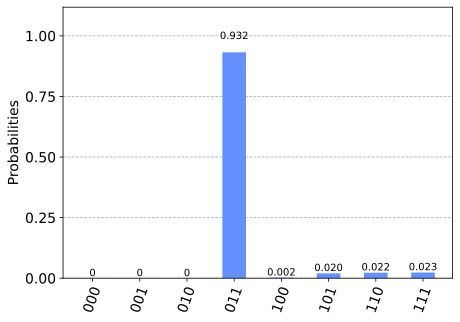

In [ ]:
plot_histogram([mitigated_counts])

That's a much better result then before!

# Quantum Adder

We build the circuit that operates the sum of two 3-qubit numbers: $|011\rangle + |010\rangle$, that should give back $|101\rangle$.

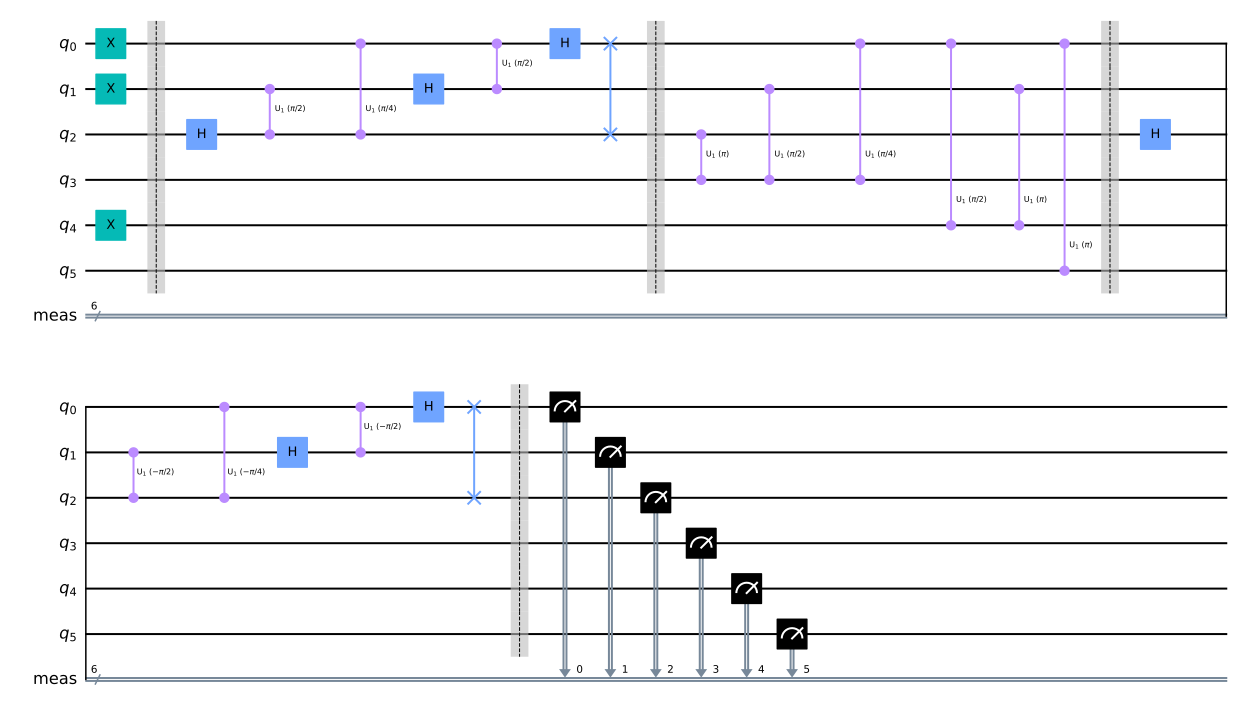

In [ ]:
adder = QuantumCircuit(6)
#INPUT
adder.x(0)
adder.x(1)
adder.x(4)
adder.barrier()

#QFT
adder.h(2)
adder.cu1(pi/2,2,1)
adder.cu1(pi/4,2,0)
adder.h(1)
adder.cu1(pi/2,0,1)
adder.h(0)
adder.swap(0,2)
adder.barrier()

#ADDER
adder.cu1(pi,3,2)
adder.cu1(pi/2,3,1)
adder.cu1(pi/4,3,0)
adder.cu1(pi/2,4,0)
adder.cu1(pi,4,1)
adder.cu1(pi,5,0)
adder.barrier()

#IQFT
adder.h(2)
adder.cu1(-pi/2,2,1)
adder.cu1(-pi/4,2,0)
adder.h(1)
adder.cu1(-np.pi/2,1,0)
adder.h(0)
adder.swap(0,2)

adder.measure_all()
adder.draw('mpl')

Let's check that the final state is the one we desire

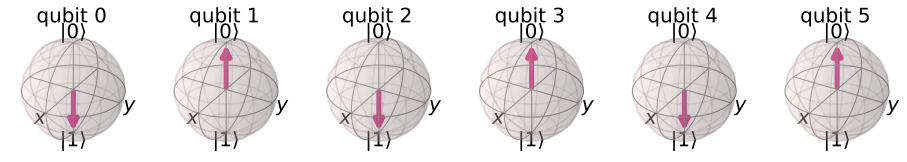

In [ ]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(adder, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

So far so good, now let's try to run it on a Quantum Computer. The only one with more than 5 qubits in the IBM Quantum Experience is ibmq_16_melbourne, with 16 qubits.

Job Status: job has successfully run


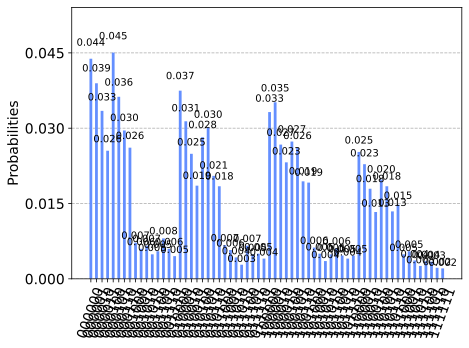

In [ ]:
backend = provider.get_backend('ibmq_16_melbourne')
shots = 8192
job = execute(adder, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)
device_result = job.result()
plot_histogram(device_result.get_counts(adder))

Not so good, the desired output, $|010101\rangle$, only obtained a $3.015\%$ probability of outcome. Let's try the qasm_simulator instead. 

Job Status: job has successfully run


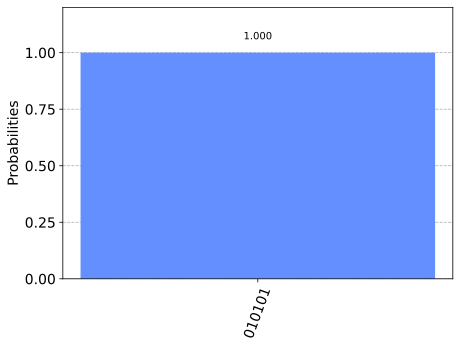

In [ ]:
backend = provider.get_backend('ibmq_qasm_simulator')
shots = 2048
job = execute(adder, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)
device_result = job.result()
plot_histogram(device_result.get_counts(adder))

This is much better. 